# Deep Learning-Based Product Recommendation System

This project presents a deep learning-based product recommendation system built using the **Amazon Products Sales Dataset 2023** from Kaggle. The objective was to generate relevant product suggestions by learning compact semantic representations from product metadata such as category, subcategory, price, and rating, without requiring user interaction data or explicit labels.

A content-based recommendation approach was implemented using a neural network autoencoder, trained to compress and reconstruct product attributes. This enabled the generation of meaningful embeddings that capture underlying relationships and similarities between items. These embeddings were then used to identify and rank similar products based on vector proximity in the latent space.

Autoencoders were selected for their effectiveness in unsupervised representation learning, making the system suitable for cold-start scenarios where user behavior is unavailable. To analyze the learned embedding space, Principal Component Analysis (PCA) was applied for dimensionality reduction and visualization, and K-Means clustering was used to validate the coherence of product groupings.

The resulting system achieved accurate and scalable recommendations, demonstrating its potential as a foundation for real-world e-commerce recommendation engines like Amazon.

---

## Library Import

In [363]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [365]:
df = pd.read_csv("/kaggle/input/amazon-products-dataset/Amazon-Products.csv")

In [366]:
df.head()

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990"
1,1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990"
2,2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990"
3,3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990"
4,4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790"


---

## Data Preparation

In [371]:
# Number of rows and columns
print(f'Number of Rows   : {df.shape[0]}')
print(f'Number of Columns: {df.shape[1]}')

Number of Rows   : 551585
Number of Columns: 10


In [373]:
# Columns Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551585 entries, 0 to 551584
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      551585 non-null  int64 
 1   name            551585 non-null  object
 2   main_category   551585 non-null  object
 3   sub_category    551585 non-null  object
 4   image           551585 non-null  object
 5   link            551585 non-null  object
 6   ratings         375791 non-null  object
 7   no_of_ratings   375791 non-null  object
 8   discount_price  490422 non-null  object
 9   actual_price    533772 non-null  object
dtypes: int64(1), object(9)
memory usage: 42.1+ MB


---

Conversion of Object variables (**'ratings', 'no_of_ratings', 'discount_price', 'actual_price'**) to float64 numeric variables.

In [377]:
# Identification of the unique values of the column ‘ratings’.
print(df['ratings'].unique())

['4.2' '4.0' '4.1' '4.3' '3.9' '3.8' '3.5' nan '4.6' '3.3' '3.4' '3.7'
 '2.9' '5.0' '4.4' '3.6' '2.7' '4.5' '3.0' '3.1' '3.2' '4.8' '4.7' '2.5'
 '1.0' '2.6' '2.8' '2.3' '1.7' 'Get' '1.8' '2.4' '4.9' '2.2' '1.6' '1.9'
 '2.0' '1.4' '2.1' 'FREE' '1.2' '1.3' '1.5' '₹68.99' '₹65' '1.1' '₹70'
 '₹100' '₹99' '₹2.99']


We can see that in the ratings column there are values that do not correspond to valid values, such as text variables **'FREE'** or numeric variables **'₹68.99'**.

In [380]:
# Replace '₹' with blanks
df['ratings'] = df['ratings'].str.replace('₹', '', regex = False)

# This automatically converts invalid values (‘Get’, FREE...) to NaN and the other values are converted to float64
df['ratings'] = pd.to_numeric(df['ratings'], errors = 'coerce')

In [381]:
# Replace the “,” with blanks in 'no_of_ratings'
df['no_of_ratings'] = df['no_of_ratings'].str.replace(',', '', regex = False)

# Converts invalid values to NaN and the other values are converted to float64
df['no_of_ratings'] = pd.to_numeric(df['no_of_ratings'], errors = 'coerce')

In [383]:
# Replace the "₹" and “,” with blanks in 'discount_price' and 'actual_price' and convert to float64
df['discount_price'] = df['discount_price'].str.replace('₹', '', regex = False).str.replace(',', '', regex = False).astype(float)
df['actual_price'] = df['actual_price'].str.replace('₹', '', regex = False).str.replace(',', '', regex = False).astype(float)

In [385]:
# Delete the column ‘Unnamed: 0’
df = df.drop('Unnamed: 0', axis = 1)

In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551585 entries, 0 to 551584
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            551585 non-null  object 
 1   main_category   551585 non-null  object 
 2   sub_category    551585 non-null  object 
 3   image           551585 non-null  object 
 4   link            551585 non-null  object 
 5   ratings         369582 non-null  float64
 6   no_of_ratings   369558 non-null  float64
 7   discount_price  490422 non-null  float64
 8   actual_price    533772 non-null  float64
dtypes: float64(4), object(5)
memory usage: 37.9+ MB


The corresponding columns were changed from **Object** to **Float**.

In [391]:
df.describe()

,ratings,no_of_ratings,discount_price,actual_price
count,369582.000000,369558.000000,4.904220e+05,5.337720e+05
mean,3.837409,840.778698,2.623161e+03,2.311128e+04
std,1.010237,8651.536018,9.458196e+03,1.355082e+07
min,1.000000,1.000000,8.000000e+00,0.000000e+00
25%,3.500000,4.000000,3.890000e+02,9.900000e+02
50%,3.900000,20.000000,6.790000e+02,1.599000e+03
75%,4.300000,133.000000,1.399000e+03,2.999000e+03
max,100.000000,589547.000000,1.249990e+06,9.900000e+09


---

We can see that in the **'ratings'** column we have values that correspond to values **above** the range of **1 to 5 stars** in the product rating.
We will filter the results by omitting these outliers or semantic values.

In [395]:
df = df[(df['ratings'] >= 1.0) & (df['ratings'] <= 5.0)]

In [396]:
df['ratings'].unique()

array([4.2 , 4.  , 4.1 , 4.3 , 3.9 , 3.8 , 3.5 , 4.6 , 3.3 , 3.4 , 3.7 ,
       2.9 , 5.  , 4.4 , 3.6 , 2.7 , 4.5 , 3.  , 3.1 , 3.2 , 4.8 , 4.7 ,
       2.5 , 1.  , 2.6 , 2.8 , 2.3 , 1.7 , 1.8 , 2.4 , 4.9 , 2.2 , 1.6 ,
       1.9 , 2.  , 1.4 , 2.1 , 1.2 , 1.3 , 1.5 , 1.1 , 2.99])

---

In [400]:
# Identify NULL values in the data frame
df.isnull().sum()

name                  0
main_category         0
sub_category          0
image                 0
link                  0
ratings               0
no_of_ratings         2
discount_price    34595
actual_price       6761
dtype: int64

In [402]:
# Replacing the Null values by the mean values of the corresponding columns.
df['no_of_ratings'] = df['no_of_ratings'].fillna(df['no_of_ratings'].mean())
df['discount_price'] = df['discount_price'].fillna(df['discount_price'].mean())
df['actual_price'] = df['actual_price'].fillna(df['actual_price'].mean())

df.isnull().sum()

name              0
main_category     0
sub_category      0
image             0
link              0
ratings           0
no_of_ratings     0
discount_price    0
actual_price      0
dtype: int64

---

Updated rupee to US dollar conversion with **exchangerate-api**.

In [406]:
import requests

api_key = "KEY"
url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/INR"

response = requests.get(url)
data = response.json()

inr_to_usd = data['conversion_rates']['USD']
print(f" 1 INR = {inr_to_usd} USD")

 1 INR = 0.01141 USD


In [408]:
num_cols = ['discount_price', 'actual_price']

for col in num_cols:
    df[col] = df[col] * inr_to_usd

df.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,2255.0,376.51859,673.0759
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,2948.0,530.45090,867.0459
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,1206.0,393.53090,707.3059
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69.0,433.46590,787.1759
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630.0,393.53090,773.4839


---

## Exploratory Data Analysis (EDA)

During the exploratory data analysis, key questions will be answered that will help to have a better understanding of the data set and will provide a lot of information for the construction of the product recommendation model.

---

**What is the main category with the highest number of user reviews in the dataset?**

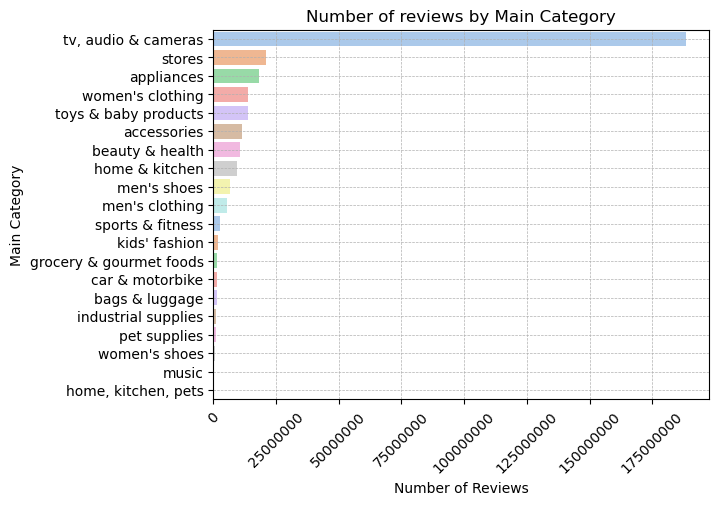

In [415]:
category_reviews = df.groupby('main_category')['no_of_ratings'].sum().sort_values(ascending = False).reset_index()

sns.barplot(data = category_reviews, x = 'no_of_ratings', y = 'main_category', palette = 'pastel')
plt.xlabel('Number of Reviews')
plt.ylabel('Main Category')
plt.xticks(rotation = 45)
plt.ticklabel_format(style = 'plain', axis = 'x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='both')
plt.title('Number of reviews by Main Category')
plt.show()

In [417]:
category_reviews['no_of_ratings'] = category_reviews['no_of_ratings'].apply(lambda x: f'{x:,.0f}')
category_reviews

,main_category,no_of_ratings
0,"tv, audio & cameras","188,337,575"
1,stores,"20,971,521"
2,appliances,"18,062,364"
3,women's clothing,"13,944,827"
4,toys & baby products,"13,819,968"
5,accessories,"11,622,796"
6,beauty & health,"10,463,387"
7,home & kitchen,"9,451,069"
8,men's shoes,"6,483,317"
9,men's clothing,"5,469,298"


We clearly observe that the category of **"tv, audio & cameras"** is the main category that has the highest number of reviwes with **188,337,575**, therefore, we conclude that it is the category that has the highest number of products sold.

---

**Which products have the highest number of reviwes for each category?**

In [422]:
idx_product_most_reviews = df.groupby('main_category')['no_of_ratings'].idxmax()
product_most_reviews = df.loc[idx_product_most_reviews, ['main_category','name','no_of_ratings']]
product_most_reviews = product_most_reviews.sort_values('no_of_ratings', ascending = False)

product_most_reviews.reset_index()

,index,main_category,name,no_of_ratings
0,60737,"tv, audio & cameras",SanDisk 128GB Class 10 microSDXC Memory Card w...,589547.0
1,721,appliances,Pigeon Polypropylene Mini Handy and Compact Ch...,274505.0
2,277867,men's clothing,Gildan Men's White Crew T-Shirt Multipack,219589.0
3,32366,toys & baby products,"Huggies Complete Comfort Wonder Pants, Medium ...",215914.0
4,506547,beauty & health,Huggies Complete Comfort Wonder Pants Extra La...,215913.0
5,265318,home & kitchen,AmazonBasics Microfiber Sheet Set - (Includes ...,190982.0
6,507020,bags & luggage,Amazon Pay eGift Card,182473.0
7,55102,accessories,Amazon Pay eGift Card,182448.0
8,332162,kids' fashion,crocs Unisex Crocband Clogs and Mules,157482.0
9,27512,stores,crocs Unisex Crocband Clogs and Mules,157480.0


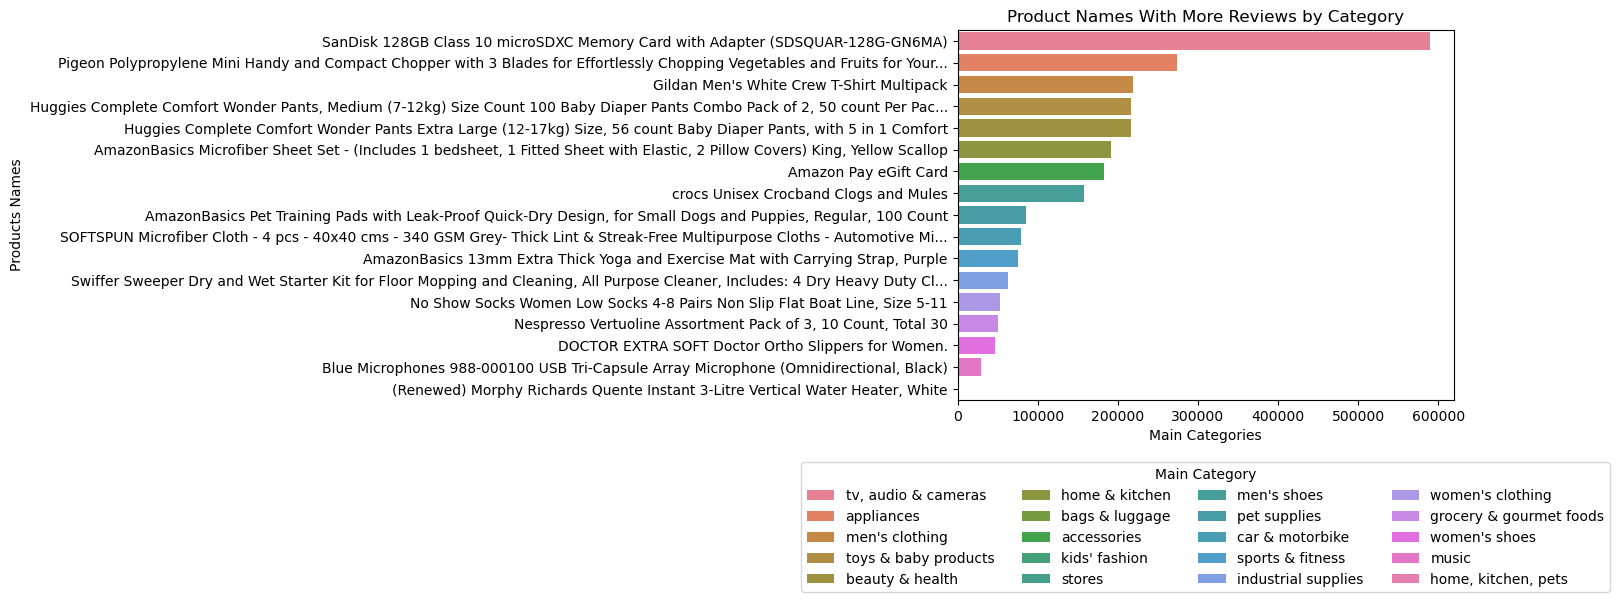

In [424]:
sns.barplot(data = product_most_reviews, x = 'no_of_ratings', y = 'name', hue = 'main_category', dodge = False)
plt.legend(loc = 'upper center', title = 'Main Category', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Products Names')
plt.xlabel('Main Categories')
plt.title('Product Names With More Reviews by Category')
plt.tight_layout()
plt.show()

We obtained the products with the highest number of reviews among the all 20 categories.

The product with the highest number of reviews by far is **“SanDisk 128GB Class 10 microSDXC Memory Card with Adapter(SDSQUAR-128G-GN6MA)”** which belongs to the **“tv, audio & cameras”** category.

---

**Is there a significant difference between products with 1 and 5 star ratings between the main categories?**

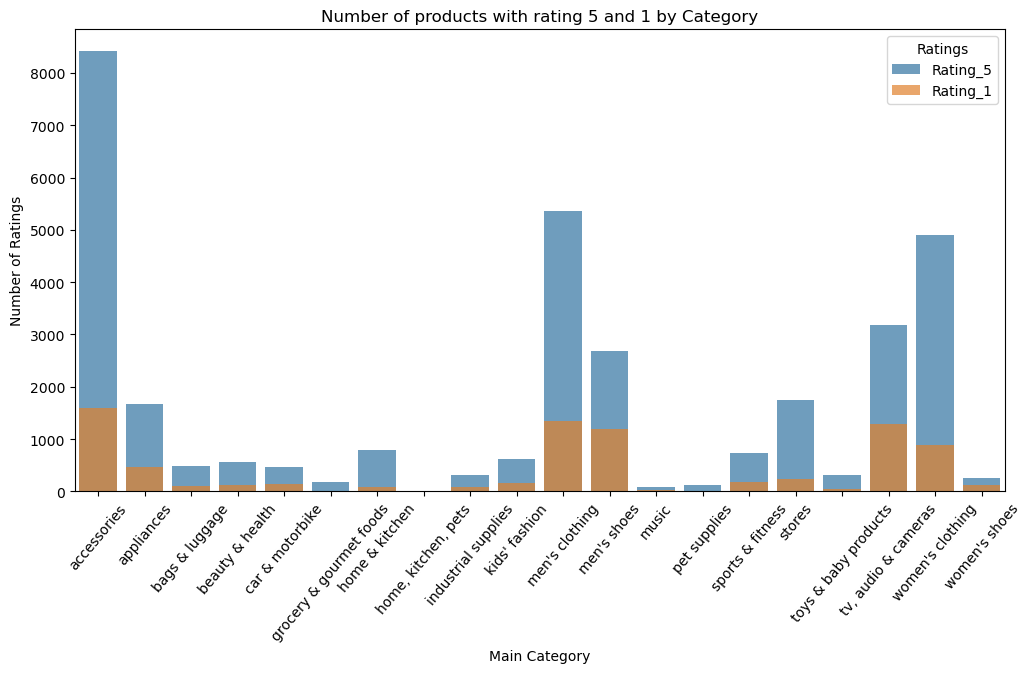

In [429]:
category_5_rating = df[df['ratings'] == 5.0].groupby('main_category').size()
category_5_rating = category_5_rating.to_frame(name = 'Rating_5').sort_values('Rating_5' ,ascending = False)

category_1_rating = df[df['ratings'] == 1.0].groupby('main_category').size()
category_1_rating = category_1_rating.to_frame(name = 'Rating_1').sort_values('Rating_1' ,ascending = False)

# product_by_category = df[ (df['main_category'] == 'tv, audio & cameras') & (df['ratings'] == 5.0) ] 

df_ratings = category_5_rating.join(category_1_rating, how='outer').fillna(0)
df_ratings = df_ratings.reset_index()

df_long = df_ratings.melt(id_vars='main_category', 
                          value_vars=['Rating_5', 'Rating_1'],
                          var_name='Ratings',
                          value_name='Count')

plt.figure(figsize=(12,6))
sns.barplot(data=df_long, x='main_category', y='Count', hue='Ratings', dodge=False, alpha=0.7)
plt.xticks(rotation=90)
plt.title('Number of products with rating 5 and 1 by Category')
plt.xlabel('Main Category')
plt.ylabel('Number of Ratings')
plt.xticks(rotation = 50)
plt.show()

In [431]:
category_5_rating

,Rating_5
main_category,
accessories,8411
men's clothing,5370
women's clothing,4905
"tv, audio & cameras",3175
men's shoes,2691
stores,1740
appliances,1666
home & kitchen,792
sports & fitness,728


In [433]:
category_1_rating

,Rating_1
main_category,
accessories,1597
men's clothing,1345
"tv, audio & cameras",1294
men's shoes,1192
women's clothing,889
appliances,467
stores,235
sports & fitness,172
kids' fashion,166


In general, the difference between **the number of products that have a ratings between 1 and 5 stars is quite considerable**, which indicates that more than 50% of the products were ranked with the best grade, while to a much lesser extent there are products ranked with the lowest grade.

The main product category in which we can observe a closer average score is “toys & baby products” with 355 products with 5 stars and 55 with 1 star. Not taking into account the category “home, kitchen, pets” as it has a very low number of products in general.

---

***What are the main categories that have the most discounted product prices?***

Text(0, 0.5, 'Main Categories')

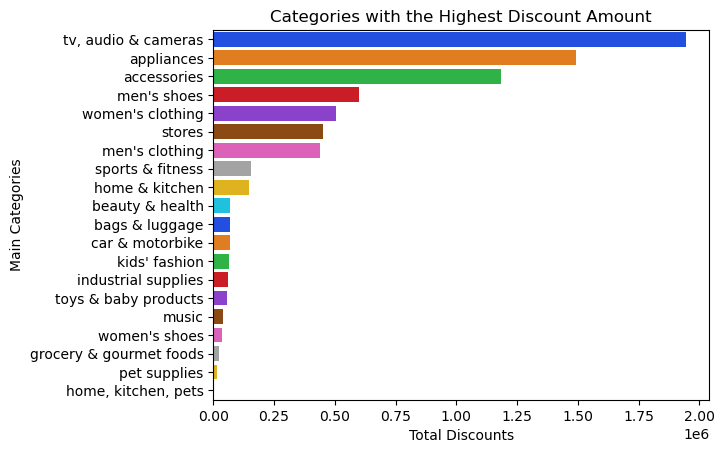

In [438]:
discount_category = df.groupby('main_category')['discount_price'].sum().sort_values(ascending = False).reset_index()

sns.barplot(data = discount_category, x = 'discount_price', y = 'main_category', hue = 'main_category', palette = 'bright')
plt.title('Categories with the Highest Discount Amount')
plt.xlabel('Total Discounts')
plt.ylabel('Main Categories')

In [440]:
discount_category

,main_category,discount_price
0,"tv, audio & cameras",1.943811e+06
1,appliances,1.491330e+06
2,accessories,1.182716e+06
3,men's shoes,6.003005e+05
4,women's clothing,5.062432e+05
5,stores,4.510392e+05
6,men's clothing,4.391330e+05
7,sports & fitness,1.536458e+05
8,home & kitchen,1.471227e+05
9,beauty & health,6.921892e+04


The main category with the **highest discount** amount is **“tv, audio & cameras”** and appilances, which corresponds to the category of products with the most reviwes and therefore with the most sales.

---

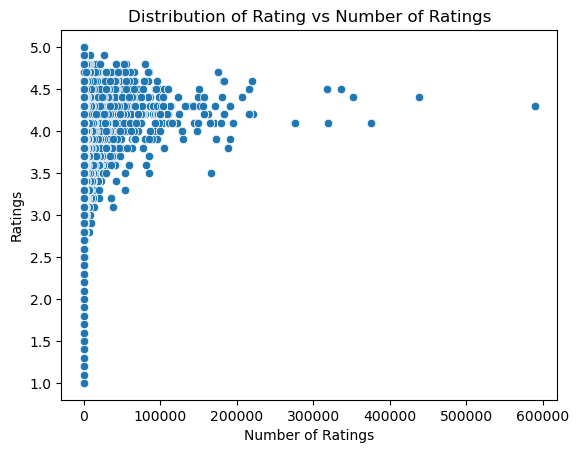

In [444]:
sns.scatterplot(data=df, x='no_of_ratings', y='ratings')
plt.title('Distribution of Rating vs Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Ratings')
plt.show()

---

**What is the rating with the highest number of reviews between 1 and 5 stars?**

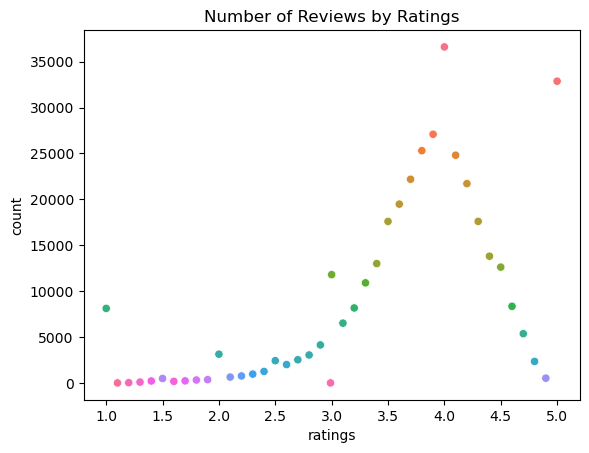

In [448]:
rating_count =  df['ratings'].value_counts().reset_index()
rating_count.columns = ['ratings', 'count']
rating_count['color_group'] = rating_count.index.astype(str)

sns.scatterplot(data = rating_count, x = 'ratings', y = 'count', hue='color_group', legend = False)
plt.title('Number of Reviews by Ratings')
plt.show()

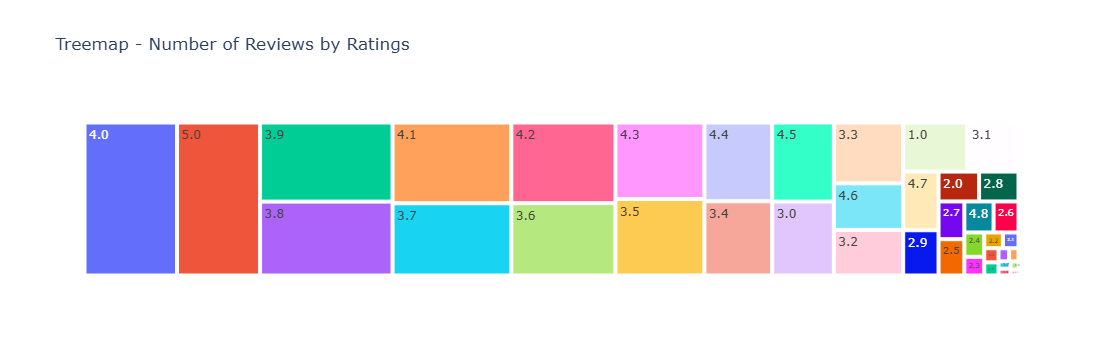

In [450]:
import plotly.express as px

ratings_count = df['ratings'].value_counts().reset_index()
ratings_count.columns = ['ratings', 'count']

fig = px.treemap(ratings_count, path = ['ratings'], values = 'count', title = 'Treemap - Number of Reviews by Ratings')
fig.show()

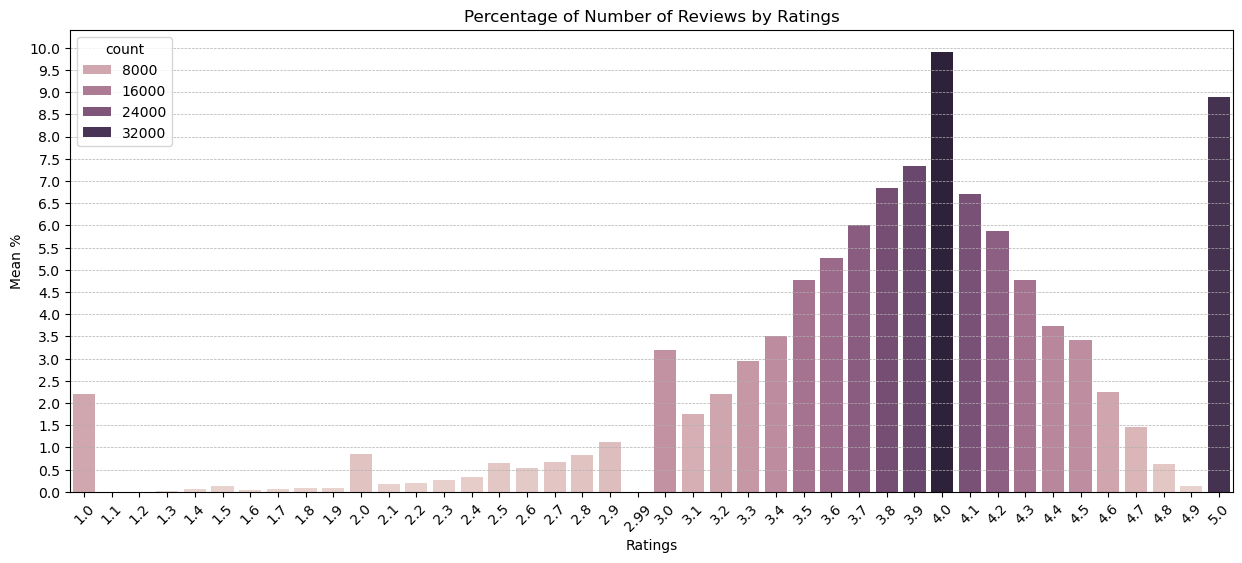

In [452]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import PercentFormatter

mean_rating_count = df['ratings'].value_counts().reset_index()
mean_rating_count.columns = ['ratings', 'count']

mean_rating_count['mean'] = mean_rating_count['count'] * 100 / mean_rating_count['count'].sum()
#mean_rating_count.sort_values('count', ascending = False)

fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data = mean_rating_count, x = 'ratings', y = 'mean', hue = 'count')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')
ax.yaxis.set_major_locator(MultipleLocator(.50))
plt.xticks(rotation = 45)
plt.title('Percentage of Number of Reviews by Ratings')
plt.ylabel('Mean %')
plt.xlabel('Ratings')
plt.show()

In [454]:
mean_rating_count = mean_rating_count.rename(columns={'mean': 'mean %'})
mean_rating_count

,ratings,count,mean %
0,4.00,36609,9.906105
1,5.00,32875,8.895714
2,3.90,27095,7.331692
3,3.80,25305,6.847332
4,4.10,24810,6.713389
5,3.70,22190,6.004438
6,4.20,21714,5.875636
7,3.60,19482,5.271674
8,4.30,17601,4.762691
9,3.50,17595,4.761067


We note that the **top 5** of the most **frequent ratings** that users rated the products are **4, 5, 3.9, 3.8, 4.1 stars** respectively, so we can conclude that in general the ratings assigned by users are quite positive.

---

### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix between Numerical Variables')

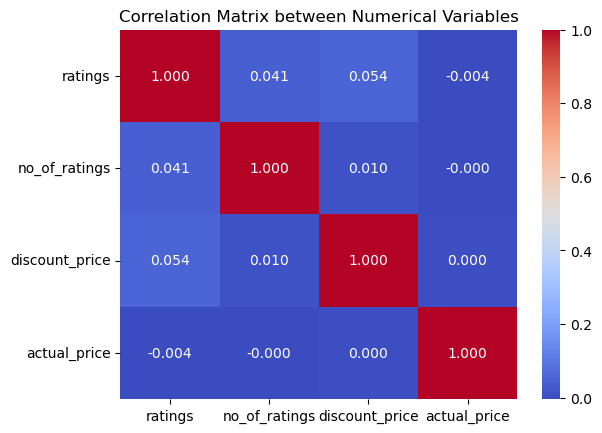

In [459]:
df_numeric = df.select_dtypes(include = ['number'])
sns.heatmap(df_numeric.corr(), annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Correlation Matrix between Numerical Variables')

---

## Model Development

An **autoencoder model** will be implemented for **recommendations of similar products**, based on an unsupervised neural network that learns to compress the input data into a smaller representation (embedding) and then attempts to reconstruct the original input from that representation.

It is a model that learns the most important characteristics of the data, eliminating the unnecessary.

In [464]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [466]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model

## <font color=blue> Autoencoder </font>

In [469]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Data Normalization
label_encoder = LabelEncoder()
df['main_category_enc'] = label_encoder.fit_transform(df['main_category'])
df['sub_category_enc'] = label_encoder.fit_transform(df['sub_category'])

# Scaling values so that they range from 0 to 1
scaler = MinMaxScaler()
numerical_col = scaler.fit_transform(df[['discount_price', 'actual_price', 'ratings', 'no_of_ratings']])

X = pd.DataFrame()
X['main_category'] = df['main_category_enc']
X['sub_category'] = df['sub_category_enc']
X[['discount_price', 'actual_price', 'ratings', 'no_of_ratings']] = numerical_col

In [471]:
# Building an autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Input dimension: 6 columns (2 categorical + 4 numerical)
# -Categorical: ['main_category_enc', 'sub_category']
# -Numerical : ['discount_price', 'actual_price', 'ratings', 'no_of_ratings']
input_dim = X.shape[1]

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
embedding = Dense(8, activation='relu', name='product_embedding')(encoded)  # <<--- Este es el vector que nos interesa

# Decoder
decoded = Dense(16, activation='relu')(embedding)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Complete model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ product_embedding (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,774 (6.93 KB)

 Trainable params: 1,774 (6.93 KB)

 Non-trainable params: 0 (0.00 B)

In [473]:
# Training the Autoencoder
# The target is to reconstruct the same input
autoencoder.fit(
    X,
    X,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 90s 5ms/step - loss: 29.3586 - val_loss: 0.0030
Epoch 2/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 3/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0021 - val_loss: 3.6542e-04
Epoch 4/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0013 - val_loss: 4.6008e-04
Epoch 5/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0016 - val_loss: 5.0458e-04
Epoch 6/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0015 - val_loss: 3.8458e-04
Epoch 7/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0011 - val_loss: 3.4375e-04
Epoch 8/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0013 - val_loss: 3.8711e-04
Epoch 9/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 7.1409e-04 - val_loss: 0.0035
Epoch 10/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0012 - val_loss: 1.3763e-04
Epoch 11/30
5197/5197 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0014 - val_loss:

In [475]:
# Model for obtaining only embeddings
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('product_embedding').output)

# Get embeddings
product_embeddings = encoder.predict(X)

11549/11549 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [477]:
# Recommendations by similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Reference product
idx = 0
vector = product_embeddings[idx].reshape(1, -1)

# Calculate similarity
similarities = cosine_similarity(vector, product_embeddings)[0]

# Get top 5 similar products (excluding itself)
top_similar = similarities.argsort()[-6:][::-1][1:]

# Display results
print("Base product: ")
print('----------------------------------')
print(df.iloc[idx][['main_category', 'sub_category', 'discount_price']])

print("\nSimilar products: ")
print('----------------------------------')
for i in top_similar:
    print(df.iloc[i][['main_category', 'sub_category', 'discount_price']])
    print('----------------------------------')
    


Base product: 
----------------------------------
main_category           appliances
sub_category      Air Conditioners
discount_price           376.51859
Name: 0, dtype: object

Similar products: 
----------------------------------
main_category           appliances
sub_category      Air Conditioners
discount_price            330.7759
Name: 44, dtype: object
----------------------------------
main_category           appliances
sub_category      Air Conditioners
discount_price            433.4659
Name: 39, dtype: object
----------------------------------
main_category           appliances
sub_category      Air Conditioners
discount_price            410.6459
Name: 151, dtype: object
----------------------------------
main_category           appliances
sub_category      Air Conditioners
discount_price           342.28859
Name: 6, dtype: object
----------------------------------
main_category           appliances
sub_category      Air Conditioners
discount_price            530.4509
Name: 

The autoencoder was able to learn useful latent representations, since when consulting a base product (an air conditioner with a discounted price of 380), it was able to retrieve other similar products of the same type (Air Conditioners) within the same main category (appliances) and with similar prices, ranging from 334 to 610. 

This indicates that the model:

- Captures semantic similarities between products, even without the need for explicit labels.
- Can be used effectively for product recommendation tasks, duplicate detection, or grouping of similar items.
- Reflects a good understanding of relevant attributes, such as category and price, in the latent space.

---

## <font color= blue > K-MEANS </font>

Agrupar productos similares entre sí en clústeres automáticamente, para descubrir patrones, segmentos de productos o mejorar la recomendación.

- K-Means te ayuda a encontrar conjuntos de productos que comparten características latentes.
- Ejemplo: todos los aire acondicionados baratos pueden caer en un clúster distinto de los premium.

In [308]:
# Obtain embeddings from the autoencoder
embeddings = encoder.predict(X)

# Apply K-Means on the embeddings
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Add cluster to the original dataframe
df['cluster'] = clusters

11549/11549 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


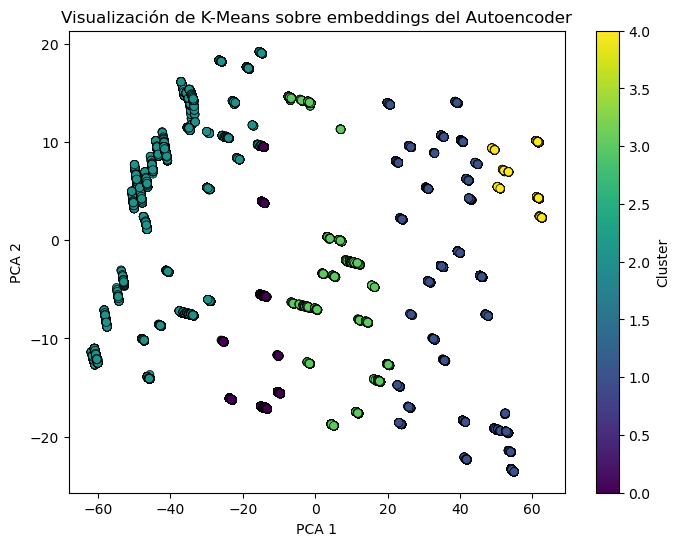

In [483]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
pca_features = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter  = plt.scatter(pca_features[:, 0], pca_features[:, 1], c = clusters, edgecolors='black', linewidths=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de K-Means sobre embeddings del Autoencoder')
plt.colorbar(scatter, label = 'Cluster')
plt.show()

K-Means clustering on the compressed embeddings was used to identify patterns and segment the data. The 2D visualization showed well-defined clusters, demonstrating that the autoencoder was able to capture meaningful representations and that the first principal components of the PCA retained the relevant structure of the data. This combination allowed us to detect similar groups without labels, which is useful for tasks such as segmentation, compression, and exploratory analysis of complex data.

---

## Conclusion

This project implemented an unsupervised learning approach to build an Amazon-style product recommendation system, using Autoencoders to learn latent representations (embeddings) from key product attributes such as category, subcategory, and price. These embeddings successfully captured meaningful similarities between items, enabling relevant product recommendations even in the absence of user behavior data.

PCA was applied for dimensionality reduction and visualization, revealing clear structure in the latent space. Subsequently, K-Means clustering validated that similar products were grouped together based on learned features. In practical tests, the model effectively recommended items from the same category (e.g., air conditioners with similar prices), replicating the logic of real-world recommendation engines like Amazon's.

In summary, this pipeline proved effective for building recommendation systems based solely on catalog data, making it highly applicable in e-commerce scenarios, particularly for cold-start situations where user history is unavailable.